In [1]:
import json
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import sgd


class Catch(object):
    def __init__(self, grid_size=10):
        self.grid_size = grid_size
        self.reset()

    def _update_state(self, action):
        """
        Input: action and states
        Ouput: new states and reward
        """
        state = self.state
        if action == 0:  # left
            action = -1
        elif action == 1:  # stay
            action = 0
        else:
            action = 1  # right
        f0, f1, basket = state[0]
        new_basket = min(max(1, basket + action), self.grid_size-1)
        f0 += 1
        out = np.asarray([f0, f1, new_basket])
        out = out[np.newaxis]

        assert len(out.shape) == 2
        self.state = out

    def _draw_state(self):
        im_size = (self.grid_size,)*2
        state = self.state[0]
        canvas = np.zeros(im_size)
        canvas[state[0], state[1]] = 1  # draw fruit
        canvas[-1, state[2]-1:state[2] + 2] = 1  # draw basket
        return canvas

    def _get_reward(self):
        fruit_row, fruit_col, basket = self.state[0]
        if fruit_row == self.grid_size-1:
            if abs(fruit_col - basket) <= 1:
                return 1
            else:
                return -1
        else:
            return 0

    def _is_over(self):
        if self.state[0, 0] == self.grid_size-1:
            return True
        else:
            return False

    def observe(self):
        canvas = self._draw_state()
        return canvas.reshape((1, -1))

    def act(self, action):
        self._update_state(action)
        reward = self._get_reward()
        game_over = self._is_over()
        return self.observe(), reward, game_over

    def reset(self):
        n = np.random.randint(0, self.grid_size-1, size=1)
        m = np.random.randint(1, self.grid_size-2, size=1)
        self.state = np.asarray([0, n, m])[np.newaxis]


class ExperienceReplay(object):
    def __init__(self, max_memory=100, discount=.9):
        self.max_memory = max_memory
        self.memory = list()
        self.discount = discount

    def remember(self, states, game_over):
        # memory[i] = [[state_t, action_t, reward_t, state_t+1], game_over?]
        self.memory.append([states, game_over])
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    def get_batch(self, model, batch_size=10):
        len_memory = len(self.memory)
        num_actions = model.output_shape[-1]
        env_dim = self.memory[0][0][0].shape[1]
        inputs = np.zeros((min(len_memory, batch_size), env_dim))
        targets = np.zeros((inputs.shape[0], num_actions))
        for i, idx in enumerate(np.random.randint(0, len_memory,
                                                  size=inputs.shape[0])):
            state_t, action_t, reward_t, state_tp1 = self.memory[idx][0]
            game_over = self.memory[idx][1]

            inputs[i:i+1] = state_t
            # There should be no target values for actions not taken.
            # Thou shalt not correct actions not taken #deep
            targets[i] = model.predict(state_t)[0]
            Q_sa = np.max(model.predict(state_tp1)[0])
            if game_over:  # if game_over is True
                targets[i, action_t] = reward_t
            else:
                # reward_t + gamma * max_a' Q(s', a')
                targets[i, action_t] = reward_t + self.discount * Q_sa
        return inputs, targets

Using TensorFlow backend.


In [2]:
    # parameters
    epsilon = .1  # exploration
    num_actions = 3  # [move_left, stay, move_right]
    epoch = 3000
    max_memory = 500
    hidden_size = 100
    batch_size = 50
    grid_size = 10

    model = Sequential()
    model.add(Dense(hidden_size, input_shape=(grid_size**2,), activation='relu'))
    model.add(Dense(hidden_size, activation='relu'))
    model.add(Dense(num_actions))
    model.compile(sgd(lr=.2), "mse")

    # If you want to continue training from a previous model, just uncomment the line bellow
    # model.load_weights("model.h5")

    # Define environment/game
    env = Catch(grid_size)

    # Initialize experience replay object
    exp_replay = ExperienceReplay(max_memory=max_memory)

    # Train
    win_cnt = 0
    
    # Save its win count history
    win_hist = []
    
    
    for e in range(epoch):  # epoch is the number of games it plays
        loss = 0.
        env.reset()
        game_over = False
        # get initial input
        input_t = env.observe()

        while not game_over:
            input_tm1 = input_t
            # get next action
            if np.random.rand() <= epsilon:
                action = np.random.randint(0, num_actions, size=1)
            else:
                q = model.predict(input_tm1)
                action = np.argmax(q[0])

            # apply action, get rewards and new state
            input_t, reward, game_over = env.act(action)
            if reward == 1:
                win_cnt += 1

            # store experience
            exp_replay.remember([input_tm1, action, reward, input_t], game_over)

            # adapt model
            inputs, targets = exp_replay.get_batch(model, batch_size=batch_size)

            # train model on experiences
            batch_loss = model.train_on_batch(inputs, targets)
            
            #print(loss)
            loss += batch_loss
            
        print("Epoch {:03d}/{:04d} | Loss {:.4f} | Win count {}".format(e, epoch, loss, win_cnt))
        win_hist.append(win_cnt)

    # Save trained model weights and architecture, this will be used by the visualization code
    model.save_weights("model.h5", overwrite=True)
    with open("model.json", "w") as outfile:
        json.dump(model.to_json(), outfile)

Epoch 000/3000 | Loss 0.0550 | Win count 0
Epoch 001/3000 | Loss 0.1623 | Win count 0
Epoch 002/3000 | Loss 0.2161 | Win count 1
Epoch 003/3000 | Loss 0.1823 | Win count 2
Epoch 004/3000 | Loss 0.2528 | Win count 2
Epoch 005/3000 | Loss 0.2238 | Win count 3
Epoch 006/3000 | Loss 0.2429 | Win count 4
Epoch 007/3000 | Loss 0.2609 | Win count 4
Epoch 008/3000 | Loss 0.2015 | Win count 4
Epoch 009/3000 | Loss 0.2678 | Win count 4
Epoch 010/3000 | Loss 0.2926 | Win count 4
Epoch 011/3000 | Loss 0.2249 | Win count 4
Epoch 012/3000 | Loss 0.1996 | Win count 4
Epoch 013/3000 | Loss 0.1877 | Win count 4
Epoch 014/3000 | Loss 0.2619 | Win count 4
Epoch 015/3000 | Loss 0.2707 | Win count 5
Epoch 016/3000 | Loss 0.2203 | Win count 5
Epoch 017/3000 | Loss 0.1982 | Win count 6
Epoch 018/3000 | Loss 0.2133 | Win count 6
Epoch 019/3000 | Loss 0.2276 | Win count 6
Epoch 020/3000 | Loss 0.1809 | Win count 7
Epoch 021/3000 | Loss 0.2188 | Win count 7
Epoch 022/3000 | Loss 0.2817 | Win count 7
Epoch 023/3

Epoch 067/3000 | Loss 0.2283 | Win count 23
Epoch 068/3000 | Loss 0.2189 | Win count 23
Epoch 069/3000 | Loss 0.1658 | Win count 23
Epoch 070/3000 | Loss 0.1748 | Win count 24
Epoch 071/3000 | Loss 0.2219 | Win count 24
Epoch 072/3000 | Loss 0.1966 | Win count 24
Epoch 073/3000 | Loss 0.1894 | Win count 24
Epoch 074/3000 | Loss 0.1848 | Win count 24
Epoch 075/3000 | Loss 0.2261 | Win count 24
Epoch 076/3000 | Loss 0.2062 | Win count 24
Epoch 077/3000 | Loss 0.1521 | Win count 25
Epoch 078/3000 | Loss 0.1798 | Win count 26
Epoch 079/3000 | Loss 0.1744 | Win count 26
Epoch 080/3000 | Loss 0.1865 | Win count 27
Epoch 081/3000 | Loss 0.2448 | Win count 27
Epoch 082/3000 | Loss 0.2144 | Win count 27
Epoch 083/3000 | Loss 0.2480 | Win count 28
Epoch 084/3000 | Loss 0.1759 | Win count 29
Epoch 085/3000 | Loss 0.1897 | Win count 30
Epoch 086/3000 | Loss 0.1809 | Win count 30
Epoch 087/3000 | Loss 0.2167 | Win count 31
Epoch 088/3000 | Loss 0.1599 | Win count 31
Epoch 089/3000 | Loss 0.1524 | W

Epoch 133/3000 | Loss 0.1500 | Win count 53
Epoch 134/3000 | Loss 0.2036 | Win count 54
Epoch 135/3000 | Loss 0.1224 | Win count 55
Epoch 136/3000 | Loss 0.1214 | Win count 56
Epoch 137/3000 | Loss 0.1467 | Win count 57
Epoch 138/3000 | Loss 0.1202 | Win count 58
Epoch 139/3000 | Loss 0.1251 | Win count 59
Epoch 140/3000 | Loss 0.1106 | Win count 60
Epoch 141/3000 | Loss 0.1135 | Win count 60
Epoch 142/3000 | Loss 0.1159 | Win count 60
Epoch 143/3000 | Loss 0.0930 | Win count 61
Epoch 144/3000 | Loss 0.1137 | Win count 61
Epoch 145/3000 | Loss 0.1184 | Win count 62
Epoch 146/3000 | Loss 0.1015 | Win count 62
Epoch 147/3000 | Loss 0.0972 | Win count 63
Epoch 148/3000 | Loss 0.0935 | Win count 64
Epoch 149/3000 | Loss 0.1097 | Win count 65
Epoch 150/3000 | Loss 0.1006 | Win count 66
Epoch 151/3000 | Loss 0.1022 | Win count 67
Epoch 152/3000 | Loss 0.1057 | Win count 67
Epoch 153/3000 | Loss 0.0865 | Win count 68
Epoch 154/3000 | Loss 0.1063 | Win count 69
Epoch 155/3000 | Loss 0.0877 | W

Epoch 199/3000 | Loss 0.0676 | Win count 95
Epoch 200/3000 | Loss 0.0734 | Win count 96
Epoch 201/3000 | Loss 0.0825 | Win count 96
Epoch 202/3000 | Loss 0.0733 | Win count 97
Epoch 203/3000 | Loss 0.0908 | Win count 98
Epoch 204/3000 | Loss 0.1076 | Win count 99
Epoch 205/3000 | Loss 0.0898 | Win count 100
Epoch 206/3000 | Loss 0.0936 | Win count 101
Epoch 207/3000 | Loss 0.0726 | Win count 102
Epoch 208/3000 | Loss 0.0703 | Win count 103
Epoch 209/3000 | Loss 0.1269 | Win count 103
Epoch 210/3000 | Loss 0.0883 | Win count 103
Epoch 211/3000 | Loss 0.0567 | Win count 103
Epoch 212/3000 | Loss 0.0885 | Win count 104
Epoch 213/3000 | Loss 0.0804 | Win count 105
Epoch 214/3000 | Loss 0.0800 | Win count 106
Epoch 215/3000 | Loss 0.0542 | Win count 107
Epoch 216/3000 | Loss 0.0988 | Win count 107
Epoch 217/3000 | Loss 0.0539 | Win count 108
Epoch 218/3000 | Loss 0.0673 | Win count 109
Epoch 219/3000 | Loss 0.0635 | Win count 110
Epoch 220/3000 | Loss 0.0764 | Win count 111
Epoch 221/3000 |

Epoch 265/3000 | Loss 0.0800 | Win count 146
Epoch 266/3000 | Loss 0.0549 | Win count 147
Epoch 267/3000 | Loss 0.0396 | Win count 148
Epoch 268/3000 | Loss 0.0474 | Win count 149
Epoch 269/3000 | Loss 0.0531 | Win count 149
Epoch 270/3000 | Loss 0.0387 | Win count 150
Epoch 271/3000 | Loss 0.0583 | Win count 151
Epoch 272/3000 | Loss 0.0653 | Win count 151
Epoch 273/3000 | Loss 0.0512 | Win count 152
Epoch 274/3000 | Loss 0.0682 | Win count 153
Epoch 275/3000 | Loss 0.0589 | Win count 153
Epoch 276/3000 | Loss 0.0469 | Win count 154
Epoch 277/3000 | Loss 0.0802 | Win count 154
Epoch 278/3000 | Loss 0.0703 | Win count 155
Epoch 279/3000 | Loss 0.0468 | Win count 155
Epoch 280/3000 | Loss 0.0728 | Win count 155
Epoch 281/3000 | Loss 0.0676 | Win count 156
Epoch 282/3000 | Loss 0.0636 | Win count 157
Epoch 283/3000 | Loss 0.0522 | Win count 158
Epoch 284/3000 | Loss 0.0486 | Win count 159
Epoch 285/3000 | Loss 0.0577 | Win count 160
Epoch 286/3000 | Loss 0.0491 | Win count 160
Epoch 287/

Epoch 331/3000 | Loss 0.0481 | Win count 192
Epoch 332/3000 | Loss 0.0539 | Win count 193
Epoch 333/3000 | Loss 0.0476 | Win count 194
Epoch 334/3000 | Loss 0.0424 | Win count 195
Epoch 335/3000 | Loss 0.0372 | Win count 196
Epoch 336/3000 | Loss 0.0502 | Win count 197
Epoch 337/3000 | Loss 0.0364 | Win count 198
Epoch 338/3000 | Loss 0.0490 | Win count 198
Epoch 339/3000 | Loss 0.0372 | Win count 199
Epoch 340/3000 | Loss 0.0376 | Win count 200
Epoch 341/3000 | Loss 0.0343 | Win count 200
Epoch 342/3000 | Loss 0.0417 | Win count 201
Epoch 343/3000 | Loss 0.0616 | Win count 202
Epoch 344/3000 | Loss 0.0506 | Win count 202
Epoch 345/3000 | Loss 0.0384 | Win count 203
Epoch 346/3000 | Loss 0.0354 | Win count 204
Epoch 347/3000 | Loss 0.0435 | Win count 204
Epoch 348/3000 | Loss 0.0488 | Win count 205
Epoch 349/3000 | Loss 0.0377 | Win count 206
Epoch 350/3000 | Loss 0.0436 | Win count 207
Epoch 351/3000 | Loss 0.0307 | Win count 208
Epoch 352/3000 | Loss 0.0350 | Win count 209
Epoch 353/

Epoch 397/3000 | Loss 0.0099 | Win count 247
Epoch 398/3000 | Loss 0.0169 | Win count 248
Epoch 399/3000 | Loss 0.0164 | Win count 249
Epoch 400/3000 | Loss 0.0188 | Win count 249
Epoch 401/3000 | Loss 0.0146 | Win count 250
Epoch 402/3000 | Loss 0.0131 | Win count 251
Epoch 403/3000 | Loss 0.0184 | Win count 252
Epoch 404/3000 | Loss 0.0110 | Win count 253
Epoch 405/3000 | Loss 0.0106 | Win count 254
Epoch 406/3000 | Loss 0.0105 | Win count 255
Epoch 407/3000 | Loss 0.0100 | Win count 256
Epoch 408/3000 | Loss 0.0077 | Win count 257
Epoch 409/3000 | Loss 0.0102 | Win count 258
Epoch 410/3000 | Loss 0.0105 | Win count 259
Epoch 411/3000 | Loss 0.0083 | Win count 260
Epoch 412/3000 | Loss 0.0093 | Win count 261
Epoch 413/3000 | Loss 0.0069 | Win count 262
Epoch 414/3000 | Loss 0.0120 | Win count 263
Epoch 415/3000 | Loss 0.0077 | Win count 264
Epoch 416/3000 | Loss 0.0111 | Win count 265
Epoch 417/3000 | Loss 0.0131 | Win count 266
Epoch 418/3000 | Loss 0.0121 | Win count 267
Epoch 419/

Epoch 463/3000 | Loss 0.0178 | Win count 307
Epoch 464/3000 | Loss 0.0288 | Win count 308
Epoch 465/3000 | Loss 0.0255 | Win count 309
Epoch 466/3000 | Loss 0.0249 | Win count 310
Epoch 467/3000 | Loss 0.0136 | Win count 310
Epoch 468/3000 | Loss 0.0268 | Win count 311
Epoch 469/3000 | Loss 0.0201 | Win count 312
Epoch 470/3000 | Loss 0.0278 | Win count 313
Epoch 471/3000 | Loss 0.0181 | Win count 314
Epoch 472/3000 | Loss 0.0168 | Win count 314
Epoch 473/3000 | Loss 0.0372 | Win count 315
Epoch 474/3000 | Loss 0.0357 | Win count 316
Epoch 475/3000 | Loss 0.0159 | Win count 317
Epoch 476/3000 | Loss 0.0181 | Win count 318
Epoch 477/3000 | Loss 0.0161 | Win count 319
Epoch 478/3000 | Loss 0.0247 | Win count 320
Epoch 479/3000 | Loss 0.0245 | Win count 321
Epoch 480/3000 | Loss 0.0442 | Win count 322
Epoch 481/3000 | Loss 0.0574 | Win count 323
Epoch 482/3000 | Loss 0.0580 | Win count 324
Epoch 483/3000 | Loss 0.0200 | Win count 325
Epoch 484/3000 | Loss 0.0494 | Win count 325
Epoch 485/

Epoch 529/3000 | Loss 0.1329 | Win count 364
Epoch 530/3000 | Loss 0.0840 | Win count 365
Epoch 531/3000 | Loss 0.0459 | Win count 366
Epoch 532/3000 | Loss 0.0522 | Win count 366
Epoch 533/3000 | Loss 0.0564 | Win count 366
Epoch 534/3000 | Loss 0.0696 | Win count 367
Epoch 535/3000 | Loss 0.0811 | Win count 368
Epoch 536/3000 | Loss 0.0584 | Win count 369
Epoch 537/3000 | Loss 0.0666 | Win count 370
Epoch 538/3000 | Loss 0.0795 | Win count 371
Epoch 539/3000 | Loss 0.0658 | Win count 371
Epoch 540/3000 | Loss 0.1129 | Win count 371
Epoch 541/3000 | Loss 0.0634 | Win count 372
Epoch 542/3000 | Loss 0.0757 | Win count 372
Epoch 543/3000 | Loss 0.0571 | Win count 373
Epoch 544/3000 | Loss 0.0600 | Win count 373
Epoch 545/3000 | Loss 0.1035 | Win count 374
Epoch 546/3000 | Loss 0.1436 | Win count 375
Epoch 547/3000 | Loss 0.0869 | Win count 376
Epoch 548/3000 | Loss 0.0531 | Win count 377
Epoch 549/3000 | Loss 0.0618 | Win count 378
Epoch 550/3000 | Loss 0.0906 | Win count 378
Epoch 551/

Epoch 595/3000 | Loss 0.0464 | Win count 407
Epoch 596/3000 | Loss 0.0574 | Win count 408
Epoch 597/3000 | Loss 0.0607 | Win count 409
Epoch 598/3000 | Loss 0.0353 | Win count 409
Epoch 599/3000 | Loss 0.0559 | Win count 410
Epoch 600/3000 | Loss 0.0646 | Win count 411
Epoch 601/3000 | Loss 0.0423 | Win count 412
Epoch 602/3000 | Loss 0.0526 | Win count 413
Epoch 603/3000 | Loss 0.0492 | Win count 414
Epoch 604/3000 | Loss 0.0448 | Win count 415
Epoch 605/3000 | Loss 0.0657 | Win count 416
Epoch 606/3000 | Loss 0.0469 | Win count 417
Epoch 607/3000 | Loss 0.0543 | Win count 418
Epoch 608/3000 | Loss 0.0574 | Win count 419
Epoch 609/3000 | Loss 0.0624 | Win count 420
Epoch 610/3000 | Loss 0.0510 | Win count 421
Epoch 611/3000 | Loss 0.0367 | Win count 421
Epoch 612/3000 | Loss 0.0327 | Win count 421
Epoch 613/3000 | Loss 0.0492 | Win count 422
Epoch 614/3000 | Loss 0.0239 | Win count 423
Epoch 615/3000 | Loss 0.0305 | Win count 424
Epoch 616/3000 | Loss 0.0272 | Win count 424
Epoch 617/

Epoch 661/3000 | Loss 0.0194 | Win count 465
Epoch 662/3000 | Loss 0.0203 | Win count 466
Epoch 663/3000 | Loss 0.0220 | Win count 467
Epoch 664/3000 | Loss 0.0233 | Win count 468
Epoch 665/3000 | Loss 0.0209 | Win count 469
Epoch 666/3000 | Loss 0.0187 | Win count 470
Epoch 667/3000 | Loss 0.0151 | Win count 471
Epoch 668/3000 | Loss 0.0211 | Win count 472
Epoch 669/3000 | Loss 0.0179 | Win count 473
Epoch 670/3000 | Loss 0.0186 | Win count 474
Epoch 671/3000 | Loss 0.0170 | Win count 475
Epoch 672/3000 | Loss 0.0177 | Win count 476
Epoch 673/3000 | Loss 0.0188 | Win count 477
Epoch 674/3000 | Loss 0.0119 | Win count 478
Epoch 675/3000 | Loss 0.0180 | Win count 479
Epoch 676/3000 | Loss 0.0136 | Win count 480
Epoch 677/3000 | Loss 0.0149 | Win count 481
Epoch 678/3000 | Loss 0.0103 | Win count 482
Epoch 679/3000 | Loss 0.0098 | Win count 483
Epoch 680/3000 | Loss 0.0108 | Win count 483
Epoch 681/3000 | Loss 0.0273 | Win count 484
Epoch 682/3000 | Loss 0.0288 | Win count 485
Epoch 683/

Epoch 727/3000 | Loss 0.0097 | Win count 526
Epoch 728/3000 | Loss 0.0118 | Win count 527
Epoch 729/3000 | Loss 0.0139 | Win count 528
Epoch 730/3000 | Loss 0.0114 | Win count 529
Epoch 731/3000 | Loss 0.0105 | Win count 530
Epoch 732/3000 | Loss 0.0127 | Win count 531
Epoch 733/3000 | Loss 0.0154 | Win count 532
Epoch 734/3000 | Loss 0.0135 | Win count 533
Epoch 735/3000 | Loss 0.0098 | Win count 534
Epoch 736/3000 | Loss 0.0127 | Win count 535
Epoch 737/3000 | Loss 0.0167 | Win count 536
Epoch 738/3000 | Loss 0.0113 | Win count 537
Epoch 739/3000 | Loss 0.0169 | Win count 538
Epoch 740/3000 | Loss 0.0127 | Win count 538
Epoch 741/3000 | Loss 0.0129 | Win count 539
Epoch 742/3000 | Loss 0.0121 | Win count 540
Epoch 743/3000 | Loss 0.0246 | Win count 541
Epoch 744/3000 | Loss 0.0260 | Win count 542
Epoch 745/3000 | Loss 0.0174 | Win count 543
Epoch 746/3000 | Loss 0.0198 | Win count 544
Epoch 747/3000 | Loss 0.0126 | Win count 545
Epoch 748/3000 | Loss 0.0145 | Win count 546
Epoch 749/

Epoch 793/3000 | Loss 0.0150 | Win count 590
Epoch 794/3000 | Loss 0.0216 | Win count 591
Epoch 795/3000 | Loss 0.0106 | Win count 592
Epoch 796/3000 | Loss 0.0200 | Win count 593
Epoch 797/3000 | Loss 0.0217 | Win count 594
Epoch 798/3000 | Loss 0.0160 | Win count 595
Epoch 799/3000 | Loss 0.0120 | Win count 596
Epoch 800/3000 | Loss 0.0211 | Win count 597
Epoch 801/3000 | Loss 0.0138 | Win count 598
Epoch 802/3000 | Loss 0.0157 | Win count 599
Epoch 803/3000 | Loss 0.0146 | Win count 600
Epoch 804/3000 | Loss 0.0102 | Win count 601
Epoch 805/3000 | Loss 0.0118 | Win count 602
Epoch 806/3000 | Loss 0.0097 | Win count 603
Epoch 807/3000 | Loss 0.0076 | Win count 604
Epoch 808/3000 | Loss 0.0064 | Win count 605
Epoch 809/3000 | Loss 0.0071 | Win count 606
Epoch 810/3000 | Loss 0.0146 | Win count 607
Epoch 811/3000 | Loss 0.0069 | Win count 607
Epoch 812/3000 | Loss 0.0065 | Win count 608
Epoch 813/3000 | Loss 0.0164 | Win count 609
Epoch 814/3000 | Loss 0.0078 | Win count 610
Epoch 815/

Epoch 859/3000 | Loss 0.0239 | Win count 651
Epoch 860/3000 | Loss 0.0200 | Win count 652
Epoch 861/3000 | Loss 0.0187 | Win count 653
Epoch 862/3000 | Loss 0.0242 | Win count 654
Epoch 863/3000 | Loss 0.0340 | Win count 655
Epoch 864/3000 | Loss 0.0112 | Win count 656
Epoch 865/3000 | Loss 0.0129 | Win count 657
Epoch 866/3000 | Loss 0.0140 | Win count 658
Epoch 867/3000 | Loss 0.0162 | Win count 659
Epoch 868/3000 | Loss 0.0118 | Win count 660
Epoch 869/3000 | Loss 0.0111 | Win count 661
Epoch 870/3000 | Loss 0.0139 | Win count 662
Epoch 871/3000 | Loss 0.0248 | Win count 662
Epoch 872/3000 | Loss 0.0143 | Win count 663
Epoch 873/3000 | Loss 0.0233 | Win count 664
Epoch 874/3000 | Loss 0.0180 | Win count 665
Epoch 875/3000 | Loss 0.0117 | Win count 666
Epoch 876/3000 | Loss 0.0332 | Win count 667
Epoch 877/3000 | Loss 0.0304 | Win count 668
Epoch 878/3000 | Loss 0.0219 | Win count 669
Epoch 879/3000 | Loss 0.0201 | Win count 670
Epoch 880/3000 | Loss 0.0339 | Win count 671
Epoch 881/

Epoch 925/3000 | Loss 0.0141 | Win count 711
Epoch 926/3000 | Loss 0.0142 | Win count 712
Epoch 927/3000 | Loss 0.0159 | Win count 713
Epoch 928/3000 | Loss 0.0117 | Win count 714
Epoch 929/3000 | Loss 0.0137 | Win count 715
Epoch 930/3000 | Loss 0.0124 | Win count 716
Epoch 931/3000 | Loss 0.0111 | Win count 717
Epoch 932/3000 | Loss 0.0118 | Win count 718
Epoch 933/3000 | Loss 0.0089 | Win count 719
Epoch 934/3000 | Loss 0.0125 | Win count 720
Epoch 935/3000 | Loss 0.0117 | Win count 721
Epoch 936/3000 | Loss 0.0128 | Win count 722
Epoch 937/3000 | Loss 0.0149 | Win count 723
Epoch 938/3000 | Loss 0.0116 | Win count 724
Epoch 939/3000 | Loss 0.0126 | Win count 725
Epoch 940/3000 | Loss 0.0110 | Win count 725
Epoch 941/3000 | Loss 0.0112 | Win count 726
Epoch 942/3000 | Loss 0.0114 | Win count 727
Epoch 943/3000 | Loss 0.0106 | Win count 728
Epoch 944/3000 | Loss 0.0150 | Win count 729
Epoch 945/3000 | Loss 0.0118 | Win count 730
Epoch 946/3000 | Loss 0.0116 | Win count 731
Epoch 947/

Epoch 991/3000 | Loss 0.0116 | Win count 774
Epoch 992/3000 | Loss 0.0082 | Win count 775
Epoch 993/3000 | Loss 0.0131 | Win count 776
Epoch 994/3000 | Loss 0.0117 | Win count 777
Epoch 995/3000 | Loss 0.0128 | Win count 778
Epoch 996/3000 | Loss 0.0119 | Win count 779
Epoch 997/3000 | Loss 0.0105 | Win count 780
Epoch 998/3000 | Loss 0.0112 | Win count 781
Epoch 999/3000 | Loss 0.0068 | Win count 782
Epoch 1000/3000 | Loss 0.0073 | Win count 783
Epoch 1001/3000 | Loss 0.0088 | Win count 784
Epoch 1002/3000 | Loss 0.0080 | Win count 785
Epoch 1003/3000 | Loss 0.0086 | Win count 786
Epoch 1004/3000 | Loss 0.0109 | Win count 787
Epoch 1005/3000 | Loss 0.0083 | Win count 787
Epoch 1006/3000 | Loss 0.0123 | Win count 788
Epoch 1007/3000 | Loss 0.0088 | Win count 789
Epoch 1008/3000 | Loss 0.0090 | Win count 790
Epoch 1009/3000 | Loss 0.0147 | Win count 791
Epoch 1010/3000 | Loss 0.0111 | Win count 792
Epoch 1011/3000 | Loss 0.0110 | Win count 793
Epoch 1012/3000 | Loss 0.0073 | Win count 7

Epoch 1056/3000 | Loss 0.0055 | Win count 836
Epoch 1057/3000 | Loss 0.0062 | Win count 837
Epoch 1058/3000 | Loss 0.0076 | Win count 838
Epoch 1059/3000 | Loss 0.0078 | Win count 839
Epoch 1060/3000 | Loss 0.0077 | Win count 840
Epoch 1061/3000 | Loss 0.0063 | Win count 841
Epoch 1062/3000 | Loss 0.0075 | Win count 842
Epoch 1063/3000 | Loss 0.0072 | Win count 842
Epoch 1064/3000 | Loss 0.0068 | Win count 843
Epoch 1065/3000 | Loss 0.0083 | Win count 844
Epoch 1066/3000 | Loss 0.0074 | Win count 845
Epoch 1067/3000 | Loss 0.0077 | Win count 845
Epoch 1068/3000 | Loss 0.0085 | Win count 846
Epoch 1069/3000 | Loss 0.0073 | Win count 847
Epoch 1070/3000 | Loss 0.0066 | Win count 848
Epoch 1071/3000 | Loss 0.0070 | Win count 849
Epoch 1072/3000 | Loss 0.0068 | Win count 850
Epoch 1073/3000 | Loss 0.0079 | Win count 851
Epoch 1074/3000 | Loss 0.0054 | Win count 852
Epoch 1075/3000 | Loss 0.0096 | Win count 853
Epoch 1076/3000 | Loss 0.0065 | Win count 854
Epoch 1077/3000 | Loss 0.0062 | Wi

Epoch 1121/3000 | Loss 0.0116 | Win count 897
Epoch 1122/3000 | Loss 0.0031 | Win count 898
Epoch 1123/3000 | Loss 0.0115 | Win count 899
Epoch 1124/3000 | Loss 0.0048 | Win count 900
Epoch 1125/3000 | Loss 0.0040 | Win count 901
Epoch 1126/3000 | Loss 0.0118 | Win count 902
Epoch 1127/3000 | Loss 0.0033 | Win count 903
Epoch 1128/3000 | Loss 0.0110 | Win count 904
Epoch 1129/3000 | Loss 0.0098 | Win count 905
Epoch 1130/3000 | Loss 0.0099 | Win count 906
Epoch 1131/3000 | Loss 0.0031 | Win count 907
Epoch 1132/3000 | Loss 0.0149 | Win count 908
Epoch 1133/3000 | Loss 0.0095 | Win count 909
Epoch 1134/3000 | Loss 0.0136 | Win count 910
Epoch 1135/3000 | Loss 0.0082 | Win count 911
Epoch 1136/3000 | Loss 0.0165 | Win count 912
Epoch 1137/3000 | Loss 0.0118 | Win count 913
Epoch 1138/3000 | Loss 0.0124 | Win count 914
Epoch 1139/3000 | Loss 0.0150 | Win count 915
Epoch 1140/3000 | Loss 0.0151 | Win count 916
Epoch 1141/3000 | Loss 0.0137 | Win count 917
Epoch 1142/3000 | Loss 0.0115 | Wi

Epoch 1186/3000 | Loss 0.0279 | Win count 954
Epoch 1187/3000 | Loss 0.0267 | Win count 955
Epoch 1188/3000 | Loss 0.0206 | Win count 955
Epoch 1189/3000 | Loss 0.0386 | Win count 956
Epoch 1190/3000 | Loss 0.0661 | Win count 957
Epoch 1191/3000 | Loss 0.0136 | Win count 958
Epoch 1192/3000 | Loss 0.0263 | Win count 958
Epoch 1193/3000 | Loss 0.0239 | Win count 959
Epoch 1194/3000 | Loss 0.0511 | Win count 960
Epoch 1195/3000 | Loss 0.0139 | Win count 961
Epoch 1196/3000 | Loss 0.0211 | Win count 962
Epoch 1197/3000 | Loss 0.0302 | Win count 963
Epoch 1198/3000 | Loss 0.0260 | Win count 964
Epoch 1199/3000 | Loss 0.0270 | Win count 965
Epoch 1200/3000 | Loss 0.0147 | Win count 966
Epoch 1201/3000 | Loss 0.0184 | Win count 967
Epoch 1202/3000 | Loss 0.0172 | Win count 968
Epoch 1203/3000 | Loss 0.0126 | Win count 969
Epoch 1204/3000 | Loss 0.0157 | Win count 970
Epoch 1205/3000 | Loss 0.0117 | Win count 971
Epoch 1206/3000 | Loss 0.0171 | Win count 972
Epoch 1207/3000 | Loss 0.0159 | Wi

Epoch 1251/3000 | Loss 0.0036 | Win count 1016
Epoch 1252/3000 | Loss 0.0032 | Win count 1017
Epoch 1253/3000 | Loss 0.0023 | Win count 1018
Epoch 1254/3000 | Loss 0.0037 | Win count 1019
Epoch 1255/3000 | Loss 0.0146 | Win count 1020
Epoch 1256/3000 | Loss 0.0034 | Win count 1021
Epoch 1257/3000 | Loss 0.0036 | Win count 1022
Epoch 1258/3000 | Loss 0.0026 | Win count 1023
Epoch 1259/3000 | Loss 0.0028 | Win count 1024
Epoch 1260/3000 | Loss 0.0026 | Win count 1025
Epoch 1261/3000 | Loss 0.0181 | Win count 1026
Epoch 1262/3000 | Loss 0.0094 | Win count 1027
Epoch 1263/3000 | Loss 0.0116 | Win count 1028
Epoch 1264/3000 | Loss 0.0029 | Win count 1029
Epoch 1265/3000 | Loss 0.0115 | Win count 1030
Epoch 1266/3000 | Loss 0.0111 | Win count 1031
Epoch 1267/3000 | Loss 0.0039 | Win count 1032
Epoch 1268/3000 | Loss 0.0033 | Win count 1033
Epoch 1269/3000 | Loss 0.0134 | Win count 1034
Epoch 1270/3000 | Loss 0.0030 | Win count 1035
Epoch 1271/3000 | Loss 0.0214 | Win count 1036
Epoch 1272/30

Epoch 1315/3000 | Loss 0.0228 | Win count 1076
Epoch 1316/3000 | Loss 0.0096 | Win count 1077
Epoch 1317/3000 | Loss 0.0232 | Win count 1078
Epoch 1318/3000 | Loss 0.0123 | Win count 1079
Epoch 1319/3000 | Loss 0.0065 | Win count 1080
Epoch 1320/3000 | Loss 0.0234 | Win count 1081
Epoch 1321/3000 | Loss 0.0324 | Win count 1081
Epoch 1322/3000 | Loss 0.0094 | Win count 1082
Epoch 1323/3000 | Loss 0.0215 | Win count 1083
Epoch 1324/3000 | Loss 0.0444 | Win count 1084
Epoch 1325/3000 | Loss 0.0319 | Win count 1085
Epoch 1326/3000 | Loss 0.0644 | Win count 1086
Epoch 1327/3000 | Loss 0.0345 | Win count 1087
Epoch 1328/3000 | Loss 0.0351 | Win count 1088
Epoch 1329/3000 | Loss 0.0246 | Win count 1089
Epoch 1330/3000 | Loss 0.0144 | Win count 1090
Epoch 1331/3000 | Loss 0.0177 | Win count 1091
Epoch 1332/3000 | Loss 0.0086 | Win count 1092
Epoch 1333/3000 | Loss 0.0165 | Win count 1093
Epoch 1334/3000 | Loss 0.0213 | Win count 1094
Epoch 1335/3000 | Loss 0.0193 | Win count 1095
Epoch 1336/30

Epoch 1379/3000 | Loss 0.0027 | Win count 1139
Epoch 1380/3000 | Loss 0.0027 | Win count 1139
Epoch 1381/3000 | Loss 0.0021 | Win count 1140
Epoch 1382/3000 | Loss 0.0065 | Win count 1141
Epoch 1383/3000 | Loss 0.0096 | Win count 1142
Epoch 1384/3000 | Loss 0.0023 | Win count 1143
Epoch 1385/3000 | Loss 0.0069 | Win count 1144
Epoch 1386/3000 | Loss 0.0019 | Win count 1145
Epoch 1387/3000 | Loss 0.0024 | Win count 1146
Epoch 1388/3000 | Loss 0.0019 | Win count 1147
Epoch 1389/3000 | Loss 0.0043 | Win count 1148
Epoch 1390/3000 | Loss 0.0017 | Win count 1149
Epoch 1391/3000 | Loss 0.0041 | Win count 1150
Epoch 1392/3000 | Loss 0.0019 | Win count 1151
Epoch 1393/3000 | Loss 0.0046 | Win count 1152
Epoch 1394/3000 | Loss 0.0061 | Win count 1153
Epoch 1395/3000 | Loss 0.0113 | Win count 1154
Epoch 1396/3000 | Loss 0.0068 | Win count 1155
Epoch 1397/3000 | Loss 0.0030 | Win count 1156
Epoch 1398/3000 | Loss 0.0070 | Win count 1157
Epoch 1399/3000 | Loss 0.0098 | Win count 1158
Epoch 1400/30

Epoch 1443/3000 | Loss 0.0059 | Win count 1201
Epoch 1444/3000 | Loss 0.0047 | Win count 1202
Epoch 1445/3000 | Loss 0.0078 | Win count 1203
Epoch 1446/3000 | Loss 0.0127 | Win count 1204
Epoch 1447/3000 | Loss 0.0060 | Win count 1205
Epoch 1448/3000 | Loss 0.0042 | Win count 1206
Epoch 1449/3000 | Loss 0.0068 | Win count 1207
Epoch 1450/3000 | Loss 0.0104 | Win count 1208
Epoch 1451/3000 | Loss 0.0076 | Win count 1209
Epoch 1452/3000 | Loss 0.0118 | Win count 1210
Epoch 1453/3000 | Loss 0.0052 | Win count 1211
Epoch 1454/3000 | Loss 0.0062 | Win count 1212
Epoch 1455/3000 | Loss 0.0124 | Win count 1213
Epoch 1456/3000 | Loss 0.0046 | Win count 1214
Epoch 1457/3000 | Loss 0.0056 | Win count 1215
Epoch 1458/3000 | Loss 0.0049 | Win count 1216
Epoch 1459/3000 | Loss 0.0051 | Win count 1217
Epoch 1460/3000 | Loss 0.0059 | Win count 1218
Epoch 1461/3000 | Loss 0.0041 | Win count 1219
Epoch 1462/3000 | Loss 0.0042 | Win count 1220
Epoch 1463/3000 | Loss 0.0042 | Win count 1221
Epoch 1464/30

Epoch 1507/3000 | Loss 0.0186 | Win count 1258
Epoch 1508/3000 | Loss 0.0088 | Win count 1259
Epoch 1509/3000 | Loss 0.0171 | Win count 1260
Epoch 1510/3000 | Loss 0.0123 | Win count 1261
Epoch 1511/3000 | Loss 0.0102 | Win count 1262
Epoch 1512/3000 | Loss 0.0135 | Win count 1263
Epoch 1513/3000 | Loss 0.0112 | Win count 1264
Epoch 1514/3000 | Loss 0.0141 | Win count 1265
Epoch 1515/3000 | Loss 0.0143 | Win count 1265
Epoch 1516/3000 | Loss 0.0131 | Win count 1266
Epoch 1517/3000 | Loss 0.0093 | Win count 1266
Epoch 1518/3000 | Loss 0.0256 | Win count 1267
Epoch 1519/3000 | Loss 0.0199 | Win count 1268
Epoch 1520/3000 | Loss 0.0206 | Win count 1269
Epoch 1521/3000 | Loss 0.0101 | Win count 1270
Epoch 1522/3000 | Loss 0.0351 | Win count 1271
Epoch 1523/3000 | Loss 0.0308 | Win count 1272
Epoch 1524/3000 | Loss 0.0068 | Win count 1273
Epoch 1525/3000 | Loss 0.0296 | Win count 1274
Epoch 1526/3000 | Loss 0.0139 | Win count 1275
Epoch 1527/3000 | Loss 0.0115 | Win count 1276
Epoch 1528/30

Epoch 1571/3000 | Loss 0.0073 | Win count 1320
Epoch 1572/3000 | Loss 0.0047 | Win count 1321
Epoch 1573/3000 | Loss 0.0068 | Win count 1322
Epoch 1574/3000 | Loss 0.0064 | Win count 1323
Epoch 1575/3000 | Loss 0.0097 | Win count 1324
Epoch 1576/3000 | Loss 0.0113 | Win count 1325
Epoch 1577/3000 | Loss 0.0052 | Win count 1326
Epoch 1578/3000 | Loss 0.0089 | Win count 1327
Epoch 1579/3000 | Loss 0.0100 | Win count 1327
Epoch 1580/3000 | Loss 0.0087 | Win count 1328
Epoch 1581/3000 | Loss 0.0055 | Win count 1329
Epoch 1582/3000 | Loss 0.0109 | Win count 1330
Epoch 1583/3000 | Loss 0.0070 | Win count 1331
Epoch 1584/3000 | Loss 0.0184 | Win count 1332
Epoch 1585/3000 | Loss 0.0101 | Win count 1333
Epoch 1586/3000 | Loss 0.0178 | Win count 1334
Epoch 1587/3000 | Loss 0.0118 | Win count 1335
Epoch 1588/3000 | Loss 0.0089 | Win count 1336
Epoch 1589/3000 | Loss 0.0091 | Win count 1336
Epoch 1590/3000 | Loss 0.0162 | Win count 1336
Epoch 1591/3000 | Loss 0.0143 | Win count 1337
Epoch 1592/30

Epoch 1635/3000 | Loss 0.0076 | Win count 1379
Epoch 1636/3000 | Loss 0.0075 | Win count 1380
Epoch 1637/3000 | Loss 0.0071 | Win count 1380
Epoch 1638/3000 | Loss 0.0152 | Win count 1381
Epoch 1639/3000 | Loss 0.0094 | Win count 1382
Epoch 1640/3000 | Loss 0.0062 | Win count 1383
Epoch 1641/3000 | Loss 0.0142 | Win count 1384
Epoch 1642/3000 | Loss 0.0087 | Win count 1385
Epoch 1643/3000 | Loss 0.0078 | Win count 1386
Epoch 1644/3000 | Loss 0.0153 | Win count 1387
Epoch 1645/3000 | Loss 0.0082 | Win count 1388
Epoch 1646/3000 | Loss 0.0105 | Win count 1389
Epoch 1647/3000 | Loss 0.0075 | Win count 1390
Epoch 1648/3000 | Loss 0.0105 | Win count 1391
Epoch 1649/3000 | Loss 0.0100 | Win count 1392
Epoch 1650/3000 | Loss 0.0117 | Win count 1393
Epoch 1651/3000 | Loss 0.0081 | Win count 1394
Epoch 1652/3000 | Loss 0.0096 | Win count 1395
Epoch 1653/3000 | Loss 0.0072 | Win count 1396
Epoch 1654/3000 | Loss 0.0091 | Win count 1397
Epoch 1655/3000 | Loss 0.0070 | Win count 1398
Epoch 1656/30

Epoch 1699/3000 | Loss 0.0087 | Win count 1440
Epoch 1700/3000 | Loss 0.0110 | Win count 1441
Epoch 1701/3000 | Loss 0.0082 | Win count 1442
Epoch 1702/3000 | Loss 0.0120 | Win count 1443
Epoch 1703/3000 | Loss 0.0042 | Win count 1444
Epoch 1704/3000 | Loss 0.0089 | Win count 1445
Epoch 1705/3000 | Loss 0.0055 | Win count 1446
Epoch 1706/3000 | Loss 0.0110 | Win count 1447
Epoch 1707/3000 | Loss 0.0075 | Win count 1448
Epoch 1708/3000 | Loss 0.0096 | Win count 1448
Epoch 1709/3000 | Loss 0.0038 | Win count 1449
Epoch 1710/3000 | Loss 0.0038 | Win count 1450
Epoch 1711/3000 | Loss 0.0063 | Win count 1451
Epoch 1712/3000 | Loss 0.0035 | Win count 1452
Epoch 1713/3000 | Loss 0.0069 | Win count 1453
Epoch 1714/3000 | Loss 0.0084 | Win count 1454
Epoch 1715/3000 | Loss 0.0056 | Win count 1455
Epoch 1716/3000 | Loss 0.0083 | Win count 1456
Epoch 1717/3000 | Loss 0.0162 | Win count 1457
Epoch 1718/3000 | Loss 0.0055 | Win count 1458
Epoch 1719/3000 | Loss 0.0147 | Win count 1459
Epoch 1720/30

Epoch 1763/3000 | Loss 0.0068 | Win count 1503
Epoch 1764/3000 | Loss 0.0076 | Win count 1504
Epoch 1765/3000 | Loss 0.0045 | Win count 1505
Epoch 1766/3000 | Loss 0.0078 | Win count 1506
Epoch 1767/3000 | Loss 0.0055 | Win count 1507
Epoch 1768/3000 | Loss 0.0040 | Win count 1508
Epoch 1769/3000 | Loss 0.0068 | Win count 1509
Epoch 1770/3000 | Loss 0.0076 | Win count 1510
Epoch 1771/3000 | Loss 0.0053 | Win count 1511
Epoch 1772/3000 | Loss 0.0051 | Win count 1511
Epoch 1773/3000 | Loss 0.0035 | Win count 1512
Epoch 1774/3000 | Loss 0.0069 | Win count 1512
Epoch 1775/3000 | Loss 0.0073 | Win count 1513
Epoch 1776/3000 | Loss 0.0045 | Win count 1514
Epoch 1777/3000 | Loss 0.0069 | Win count 1515
Epoch 1778/3000 | Loss 0.0049 | Win count 1516
Epoch 1779/3000 | Loss 0.0031 | Win count 1517
Epoch 1780/3000 | Loss 0.0069 | Win count 1518
Epoch 1781/3000 | Loss 0.0047 | Win count 1519
Epoch 1782/3000 | Loss 0.0056 | Win count 1520
Epoch 1783/3000 | Loss 0.0046 | Win count 1521
Epoch 1784/30

Epoch 1827/3000 | Loss 0.0088 | Win count 1563
Epoch 1828/3000 | Loss 0.0079 | Win count 1564
Epoch 1829/3000 | Loss 0.0307 | Win count 1565
Epoch 1830/3000 | Loss 0.0169 | Win count 1566
Epoch 1831/3000 | Loss 0.0106 | Win count 1567
Epoch 1832/3000 | Loss 0.0264 | Win count 1568
Epoch 1833/3000 | Loss 0.0235 | Win count 1569
Epoch 1834/3000 | Loss 0.0236 | Win count 1570
Epoch 1835/3000 | Loss 0.0130 | Win count 1571
Epoch 1836/3000 | Loss 0.0281 | Win count 1572
Epoch 1837/3000 | Loss 0.0107 | Win count 1573
Epoch 1838/3000 | Loss 0.0158 | Win count 1574
Epoch 1839/3000 | Loss 0.0122 | Win count 1575
Epoch 1840/3000 | Loss 0.0164 | Win count 1576
Epoch 1841/3000 | Loss 0.0164 | Win count 1577
Epoch 1842/3000 | Loss 0.0127 | Win count 1578
Epoch 1843/3000 | Loss 0.0128 | Win count 1579
Epoch 1844/3000 | Loss 0.0092 | Win count 1580
Epoch 1845/3000 | Loss 0.0110 | Win count 1581
Epoch 1846/3000 | Loss 0.0083 | Win count 1582
Epoch 1847/3000 | Loss 0.0051 | Win count 1583
Epoch 1848/30

Epoch 1891/3000 | Loss 0.0131 | Win count 1625
Epoch 1892/3000 | Loss 0.0119 | Win count 1626
Epoch 1893/3000 | Loss 0.0091 | Win count 1626
Epoch 1894/3000 | Loss 0.0126 | Win count 1627
Epoch 1895/3000 | Loss 0.0090 | Win count 1627
Epoch 1896/3000 | Loss 0.0181 | Win count 1628
Epoch 1897/3000 | Loss 0.0164 | Win count 1629
Epoch 1898/3000 | Loss 0.0154 | Win count 1630
Epoch 1899/3000 | Loss 0.0177 | Win count 1631
Epoch 1900/3000 | Loss 0.0169 | Win count 1632
Epoch 1901/3000 | Loss 0.0081 | Win count 1633
Epoch 1902/3000 | Loss 0.0067 | Win count 1634
Epoch 1903/3000 | Loss 0.0083 | Win count 1635
Epoch 1904/3000 | Loss 0.0126 | Win count 1636
Epoch 1905/3000 | Loss 0.0088 | Win count 1637
Epoch 1906/3000 | Loss 0.0131 | Win count 1638
Epoch 1907/3000 | Loss 0.0100 | Win count 1639
Epoch 1908/3000 | Loss 0.0122 | Win count 1640
Epoch 1909/3000 | Loss 0.0086 | Win count 1641
Epoch 1910/3000 | Loss 0.0093 | Win count 1642
Epoch 1911/3000 | Loss 0.0129 | Win count 1643
Epoch 1912/30

Epoch 1955/3000 | Loss 0.0055 | Win count 1686
Epoch 1956/3000 | Loss 0.0045 | Win count 1687
Epoch 1957/3000 | Loss 0.0042 | Win count 1688
Epoch 1958/3000 | Loss 0.0048 | Win count 1689
Epoch 1959/3000 | Loss 0.0039 | Win count 1690
Epoch 1960/3000 | Loss 0.0044 | Win count 1691
Epoch 1961/3000 | Loss 0.0031 | Win count 1692
Epoch 1962/3000 | Loss 0.0052 | Win count 1693
Epoch 1963/3000 | Loss 0.0071 | Win count 1694
Epoch 1964/3000 | Loss 0.0030 | Win count 1695
Epoch 1965/3000 | Loss 0.0029 | Win count 1696
Epoch 1966/3000 | Loss 0.0035 | Win count 1697
Epoch 1967/3000 | Loss 0.0040 | Win count 1698
Epoch 1968/3000 | Loss 0.0042 | Win count 1699
Epoch 1969/3000 | Loss 0.0037 | Win count 1700
Epoch 1970/3000 | Loss 0.0047 | Win count 1701
Epoch 1971/3000 | Loss 0.0037 | Win count 1702
Epoch 1972/3000 | Loss 0.0029 | Win count 1703
Epoch 1973/3000 | Loss 0.0025 | Win count 1704
Epoch 1974/3000 | Loss 0.0040 | Win count 1705
Epoch 1975/3000 | Loss 0.0029 | Win count 1706
Epoch 1976/30

Epoch 2019/3000 | Loss 0.0050 | Win count 1748
Epoch 2020/3000 | Loss 0.0045 | Win count 1748
Epoch 2021/3000 | Loss 0.0044 | Win count 1749
Epoch 2022/3000 | Loss 0.0040 | Win count 1750
Epoch 2023/3000 | Loss 0.0044 | Win count 1751
Epoch 2024/3000 | Loss 0.0035 | Win count 1752
Epoch 2025/3000 | Loss 0.0037 | Win count 1753
Epoch 2026/3000 | Loss 0.0025 | Win count 1754
Epoch 2027/3000 | Loss 0.0042 | Win count 1755
Epoch 2028/3000 | Loss 0.0036 | Win count 1756
Epoch 2029/3000 | Loss 0.0023 | Win count 1757
Epoch 2030/3000 | Loss 0.0034 | Win count 1758
Epoch 2031/3000 | Loss 0.0028 | Win count 1759
Epoch 2032/3000 | Loss 0.0058 | Win count 1760
Epoch 2033/3000 | Loss 0.0042 | Win count 1761
Epoch 2034/3000 | Loss 0.0049 | Win count 1762
Epoch 2035/3000 | Loss 0.0052 | Win count 1763
Epoch 2036/3000 | Loss 0.0039 | Win count 1764
Epoch 2037/3000 | Loss 0.0039 | Win count 1765
Epoch 2038/3000 | Loss 0.0026 | Win count 1766
Epoch 2039/3000 | Loss 0.0043 | Win count 1767
Epoch 2040/30

Epoch 2083/3000 | Loss 0.0046 | Win count 1810
Epoch 2084/3000 | Loss 0.0084 | Win count 1811
Epoch 2085/3000 | Loss 0.0054 | Win count 1812
Epoch 2086/3000 | Loss 0.0071 | Win count 1813
Epoch 2087/3000 | Loss 0.0065 | Win count 1814
Epoch 2088/3000 | Loss 0.0038 | Win count 1815
Epoch 2089/3000 | Loss 0.0043 | Win count 1816
Epoch 2090/3000 | Loss 0.0032 | Win count 1817
Epoch 2091/3000 | Loss 0.0042 | Win count 1818
Epoch 2092/3000 | Loss 0.0043 | Win count 1819
Epoch 2093/3000 | Loss 0.0036 | Win count 1820
Epoch 2094/3000 | Loss 0.0103 | Win count 1821
Epoch 2095/3000 | Loss 0.0114 | Win count 1822
Epoch 2096/3000 | Loss 0.0040 | Win count 1823
Epoch 2097/3000 | Loss 0.0052 | Win count 1824
Epoch 2098/3000 | Loss 0.0056 | Win count 1825
Epoch 2099/3000 | Loss 0.0046 | Win count 1826
Epoch 2100/3000 | Loss 0.0029 | Win count 1827
Epoch 2101/3000 | Loss 0.0038 | Win count 1828
Epoch 2102/3000 | Loss 0.0051 | Win count 1829
Epoch 2103/3000 | Loss 0.0042 | Win count 1830
Epoch 2104/30

Epoch 2147/3000 | Loss 0.0139 | Win count 1872
Epoch 2148/3000 | Loss 0.0162 | Win count 1872
Epoch 2149/3000 | Loss 0.0081 | Win count 1873
Epoch 2150/3000 | Loss 0.0044 | Win count 1874
Epoch 2151/3000 | Loss 0.0082 | Win count 1875
Epoch 2152/3000 | Loss 0.0413 | Win count 1875
Epoch 2153/3000 | Loss 0.0120 | Win count 1876
Epoch 2154/3000 | Loss 0.0117 | Win count 1877
Epoch 2155/3000 | Loss 0.0213 | Win count 1878
Epoch 2156/3000 | Loss 0.0541 | Win count 1879
Epoch 2157/3000 | Loss 0.0128 | Win count 1880
Epoch 2158/3000 | Loss 0.0377 | Win count 1881
Epoch 2159/3000 | Loss 0.0123 | Win count 1882
Epoch 2160/3000 | Loss 0.0488 | Win count 1883
Epoch 2161/3000 | Loss 0.0208 | Win count 1884
Epoch 2162/3000 | Loss 0.0241 | Win count 1885
Epoch 2163/3000 | Loss 0.0161 | Win count 1886
Epoch 2164/3000 | Loss 0.0159 | Win count 1887
Epoch 2165/3000 | Loss 0.0088 | Win count 1888
Epoch 2166/3000 | Loss 0.0172 | Win count 1889
Epoch 2167/3000 | Loss 0.0049 | Win count 1890
Epoch 2168/30

Epoch 2211/3000 | Loss 0.0028 | Win count 1932
Epoch 2212/3000 | Loss 0.0024 | Win count 1933
Epoch 2213/3000 | Loss 0.0101 | Win count 1934
Epoch 2214/3000 | Loss 0.0102 | Win count 1935
Epoch 2215/3000 | Loss 0.0060 | Win count 1936
Epoch 2216/3000 | Loss 0.0045 | Win count 1937
Epoch 2217/3000 | Loss 0.0029 | Win count 1938
Epoch 2218/3000 | Loss 0.0067 | Win count 1939
Epoch 2219/3000 | Loss 0.0051 | Win count 1940
Epoch 2220/3000 | Loss 0.0047 | Win count 1941
Epoch 2221/3000 | Loss 0.0056 | Win count 1942
Epoch 2222/3000 | Loss 0.0054 | Win count 1943
Epoch 2223/3000 | Loss 0.0066 | Win count 1944
Epoch 2224/3000 | Loss 0.0028 | Win count 1945
Epoch 2225/3000 | Loss 0.0026 | Win count 1946
Epoch 2226/3000 | Loss 0.0031 | Win count 1947
Epoch 2227/3000 | Loss 0.0054 | Win count 1948
Epoch 2228/3000 | Loss 0.0041 | Win count 1949
Epoch 2229/3000 | Loss 0.0018 | Win count 1950
Epoch 2230/3000 | Loss 0.0039 | Win count 1951
Epoch 2231/3000 | Loss 0.0041 | Win count 1952
Epoch 2232/30

Epoch 2275/3000 | Loss 0.0032 | Win count 1994
Epoch 2276/3000 | Loss 0.0045 | Win count 1995
Epoch 2277/3000 | Loss 0.0034 | Win count 1996
Epoch 2278/3000 | Loss 0.0032 | Win count 1997
Epoch 2279/3000 | Loss 0.0030 | Win count 1998
Epoch 2280/3000 | Loss 0.0027 | Win count 1999
Epoch 2281/3000 | Loss 0.0023 | Win count 2000
Epoch 2282/3000 | Loss 0.0035 | Win count 2001
Epoch 2283/3000 | Loss 0.0028 | Win count 2002
Epoch 2284/3000 | Loss 0.0029 | Win count 2003
Epoch 2285/3000 | Loss 0.0023 | Win count 2004
Epoch 2286/3000 | Loss 0.0020 | Win count 2005
Epoch 2287/3000 | Loss 0.0016 | Win count 2006
Epoch 2288/3000 | Loss 0.0028 | Win count 2007
Epoch 2289/3000 | Loss 0.0020 | Win count 2008
Epoch 2290/3000 | Loss 0.0031 | Win count 2009
Epoch 2291/3000 | Loss 0.0031 | Win count 2010
Epoch 2292/3000 | Loss 0.0032 | Win count 2010
Epoch 2293/3000 | Loss 0.0052 | Win count 2011
Epoch 2294/3000 | Loss 0.0029 | Win count 2012
Epoch 2295/3000 | Loss 0.0028 | Win count 2013
Epoch 2296/30

Epoch 2339/3000 | Loss 0.0018 | Win count 2054
Epoch 2340/3000 | Loss 0.0033 | Win count 2055
Epoch 2341/3000 | Loss 0.0029 | Win count 2056
Epoch 2342/3000 | Loss 0.0025 | Win count 2057
Epoch 2343/3000 | Loss 0.0020 | Win count 2058
Epoch 2344/3000 | Loss 0.0020 | Win count 2059
Epoch 2345/3000 | Loss 0.0018 | Win count 2060
Epoch 2346/3000 | Loss 0.0015 | Win count 2061
Epoch 2347/3000 | Loss 0.0034 | Win count 2062
Epoch 2348/3000 | Loss 0.0041 | Win count 2063
Epoch 2349/3000 | Loss 0.0034 | Win count 2064
Epoch 2350/3000 | Loss 0.0015 | Win count 2065
Epoch 2351/3000 | Loss 0.0045 | Win count 2066
Epoch 2352/3000 | Loss 0.0019 | Win count 2067
Epoch 2353/3000 | Loss 0.0019 | Win count 2068
Epoch 2354/3000 | Loss 0.0020 | Win count 2069
Epoch 2355/3000 | Loss 0.0025 | Win count 2070
Epoch 2356/3000 | Loss 0.0023 | Win count 2071
Epoch 2357/3000 | Loss 0.0029 | Win count 2072
Epoch 2358/3000 | Loss 0.0043 | Win count 2073
Epoch 2359/3000 | Loss 0.0027 | Win count 2074
Epoch 2360/30

Epoch 2403/3000 | Loss 0.0018 | Win count 2118
Epoch 2404/3000 | Loss 0.0021 | Win count 2119
Epoch 2405/3000 | Loss 0.0017 | Win count 2120
Epoch 2406/3000 | Loss 0.0018 | Win count 2121
Epoch 2407/3000 | Loss 0.0027 | Win count 2122
Epoch 2408/3000 | Loss 0.0022 | Win count 2123
Epoch 2409/3000 | Loss 0.0018 | Win count 2124
Epoch 2410/3000 | Loss 0.0019 | Win count 2124
Epoch 2411/3000 | Loss 0.0065 | Win count 2125
Epoch 2412/3000 | Loss 0.0036 | Win count 2126
Epoch 2413/3000 | Loss 0.0037 | Win count 2126
Epoch 2414/3000 | Loss 0.0120 | Win count 2127
Epoch 2415/3000 | Loss 0.0042 | Win count 2128
Epoch 2416/3000 | Loss 0.0083 | Win count 2129
Epoch 2417/3000 | Loss 0.0199 | Win count 2129
Epoch 2418/3000 | Loss 0.0179 | Win count 2130
Epoch 2419/3000 | Loss 0.0081 | Win count 2131
Epoch 2420/3000 | Loss 0.0089 | Win count 2132
Epoch 2421/3000 | Loss 0.0164 | Win count 2133
Epoch 2422/3000 | Loss 0.0055 | Win count 2134
Epoch 2423/3000 | Loss 0.0069 | Win count 2134
Epoch 2424/30

Epoch 2467/3000 | Loss 0.0024 | Win count 2177
Epoch 2468/3000 | Loss 0.0022 | Win count 2178
Epoch 2469/3000 | Loss 0.0020 | Win count 2179
Epoch 2470/3000 | Loss 0.0022 | Win count 2179
Epoch 2471/3000 | Loss 0.0135 | Win count 2180
Epoch 2472/3000 | Loss 0.0022 | Win count 2181
Epoch 2473/3000 | Loss 0.0127 | Win count 2182
Epoch 2474/3000 | Loss 0.0019 | Win count 2183
Epoch 2475/3000 | Loss 0.0019 | Win count 2184
Epoch 2476/3000 | Loss 0.0029 | Win count 2185
Epoch 2477/3000 | Loss 0.0194 | Win count 2186
Epoch 2478/3000 | Loss 0.0179 | Win count 2187
Epoch 2479/3000 | Loss 0.0154 | Win count 2188
Epoch 2480/3000 | Loss 0.0088 | Win count 2189
Epoch 2481/3000 | Loss 0.0175 | Win count 2190
Epoch 2482/3000 | Loss 0.0122 | Win count 2191
Epoch 2483/3000 | Loss 0.0070 | Win count 2192
Epoch 2484/3000 | Loss 0.0113 | Win count 2192
Epoch 2485/3000 | Loss 0.0032 | Win count 2193
Epoch 2486/3000 | Loss 0.0111 | Win count 2194
Epoch 2487/3000 | Loss 0.0075 | Win count 2195
Epoch 2488/30

Epoch 2531/3000 | Loss 0.0072 | Win count 2237
Epoch 2532/3000 | Loss 0.0029 | Win count 2238
Epoch 2533/3000 | Loss 0.0056 | Win count 2238
Epoch 2534/3000 | Loss 0.0045 | Win count 2239
Epoch 2535/3000 | Loss 0.0072 | Win count 2240
Epoch 2536/3000 | Loss 0.0034 | Win count 2241
Epoch 2537/3000 | Loss 0.0061 | Win count 2242
Epoch 2538/3000 | Loss 0.0034 | Win count 2243
Epoch 2539/3000 | Loss 0.0062 | Win count 2243
Epoch 2540/3000 | Loss 0.0068 | Win count 2244
Epoch 2541/3000 | Loss 0.0029 | Win count 2245
Epoch 2542/3000 | Loss 0.0036 | Win count 2246
Epoch 2543/3000 | Loss 0.0041 | Win count 2247
Epoch 2544/3000 | Loss 0.0026 | Win count 2248
Epoch 2545/3000 | Loss 0.0028 | Win count 2249
Epoch 2546/3000 | Loss 0.0031 | Win count 2250
Epoch 2547/3000 | Loss 0.0031 | Win count 2251
Epoch 2548/3000 | Loss 0.0044 | Win count 2252
Epoch 2549/3000 | Loss 0.0031 | Win count 2253
Epoch 2550/3000 | Loss 0.0030 | Win count 2254
Epoch 2551/3000 | Loss 0.0026 | Win count 2255
Epoch 2552/30

Epoch 2595/3000 | Loss 0.0032 | Win count 2299
Epoch 2596/3000 | Loss 0.0054 | Win count 2300
Epoch 2597/3000 | Loss 0.0022 | Win count 2301
Epoch 2598/3000 | Loss 0.0020 | Win count 2302
Epoch 2599/3000 | Loss 0.0020 | Win count 2303
Epoch 2600/3000 | Loss 0.0055 | Win count 2304
Epoch 2601/3000 | Loss 0.0051 | Win count 2305
Epoch 2602/3000 | Loss 0.0040 | Win count 2306
Epoch 2603/3000 | Loss 0.0030 | Win count 2307
Epoch 2604/3000 | Loss 0.0016 | Win count 2308
Epoch 2605/3000 | Loss 0.0021 | Win count 2309
Epoch 2606/3000 | Loss 0.0020 | Win count 2310
Epoch 2607/3000 | Loss 0.0018 | Win count 2310
Epoch 2608/3000 | Loss 0.0026 | Win count 2311
Epoch 2609/3000 | Loss 0.0037 | Win count 2312
Epoch 2610/3000 | Loss 0.0018 | Win count 2313
Epoch 2611/3000 | Loss 0.0050 | Win count 2314
Epoch 2612/3000 | Loss 0.0023 | Win count 2315
Epoch 2613/3000 | Loss 0.0030 | Win count 2315
Epoch 2614/3000 | Loss 0.0049 | Win count 2315
Epoch 2615/3000 | Loss 0.0078 | Win count 2316
Epoch 2616/30

Epoch 2659/3000 | Loss 0.0095 | Win count 2355
Epoch 2660/3000 | Loss 0.0039 | Win count 2356
Epoch 2661/3000 | Loss 0.0167 | Win count 2357
Epoch 2662/3000 | Loss 0.0197 | Win count 2358
Epoch 2663/3000 | Loss 0.0132 | Win count 2359
Epoch 2664/3000 | Loss 0.0192 | Win count 2360
Epoch 2665/3000 | Loss 0.0254 | Win count 2361
Epoch 2666/3000 | Loss 0.0196 | Win count 2362
Epoch 2667/3000 | Loss 0.0112 | Win count 2363
Epoch 2668/3000 | Loss 0.0164 | Win count 2364
Epoch 2669/3000 | Loss 0.0246 | Win count 2365
Epoch 2670/3000 | Loss 0.0150 | Win count 2366
Epoch 2671/3000 | Loss 0.0137 | Win count 2367
Epoch 2672/3000 | Loss 0.0043 | Win count 2368
Epoch 2673/3000 | Loss 0.0060 | Win count 2369
Epoch 2674/3000 | Loss 0.0156 | Win count 2370
Epoch 2675/3000 | Loss 0.0179 | Win count 2371
Epoch 2676/3000 | Loss 0.0106 | Win count 2372
Epoch 2677/3000 | Loss 0.0082 | Win count 2373
Epoch 2678/3000 | Loss 0.0049 | Win count 2374
Epoch 2679/3000 | Loss 0.0114 | Win count 2375
Epoch 2680/30

Epoch 2723/3000 | Loss 0.0049 | Win count 2418
Epoch 2724/3000 | Loss 0.0033 | Win count 2419
Epoch 2725/3000 | Loss 0.0047 | Win count 2420
Epoch 2726/3000 | Loss 0.0021 | Win count 2421
Epoch 2727/3000 | Loss 0.0019 | Win count 2422
Epoch 2728/3000 | Loss 0.0018 | Win count 2423
Epoch 2729/3000 | Loss 0.0030 | Win count 2424
Epoch 2730/3000 | Loss 0.0035 | Win count 2425
Epoch 2731/3000 | Loss 0.0029 | Win count 2426
Epoch 2732/3000 | Loss 0.0019 | Win count 2427
Epoch 2733/3000 | Loss 0.0022 | Win count 2428
Epoch 2734/3000 | Loss 0.0014 | Win count 2429
Epoch 2735/3000 | Loss 0.0026 | Win count 2430
Epoch 2736/3000 | Loss 0.0018 | Win count 2431
Epoch 2737/3000 | Loss 0.0029 | Win count 2432
Epoch 2738/3000 | Loss 0.0024 | Win count 2433
Epoch 2739/3000 | Loss 0.0022 | Win count 2434
Epoch 2740/3000 | Loss 0.0023 | Win count 2435
Epoch 2741/3000 | Loss 0.0023 | Win count 2436
Epoch 2742/3000 | Loss 0.0022 | Win count 2437
Epoch 2743/3000 | Loss 0.0031 | Win count 2438
Epoch 2744/30

Epoch 2787/3000 | Loss 0.0103 | Win count 2480
Epoch 2788/3000 | Loss 0.0098 | Win count 2481
Epoch 2789/3000 | Loss 0.0081 | Win count 2482
Epoch 2790/3000 | Loss 0.0098 | Win count 2483
Epoch 2791/3000 | Loss 0.0070 | Win count 2484
Epoch 2792/3000 | Loss 0.0087 | Win count 2485
Epoch 2793/3000 | Loss 0.0082 | Win count 2486
Epoch 2794/3000 | Loss 0.0075 | Win count 2487
Epoch 2795/3000 | Loss 0.0064 | Win count 2488
Epoch 2796/3000 | Loss 0.0143 | Win count 2489
Epoch 2797/3000 | Loss 0.0070 | Win count 2490
Epoch 2798/3000 | Loss 0.0067 | Win count 2491
Epoch 2799/3000 | Loss 0.0077 | Win count 2492
Epoch 2800/3000 | Loss 0.0064 | Win count 2493
Epoch 2801/3000 | Loss 0.0073 | Win count 2494
Epoch 2802/3000 | Loss 0.0068 | Win count 2495
Epoch 2803/3000 | Loss 0.0067 | Win count 2495
Epoch 2804/3000 | Loss 0.0078 | Win count 2496
Epoch 2805/3000 | Loss 0.0058 | Win count 2497
Epoch 2806/3000 | Loss 0.0197 | Win count 2498
Epoch 2807/3000 | Loss 0.0068 | Win count 2499
Epoch 2808/30

Epoch 2851/3000 | Loss 0.0094 | Win count 2539
Epoch 2852/3000 | Loss 0.0247 | Win count 2540
Epoch 2853/3000 | Loss 0.0235 | Win count 2540
Epoch 2854/3000 | Loss 0.0298 | Win count 2540
Epoch 2855/3000 | Loss 0.0313 | Win count 2541
Epoch 2856/3000 | Loss 0.0412 | Win count 2542
Epoch 2857/3000 | Loss 0.0224 | Win count 2543
Epoch 2858/3000 | Loss 0.0389 | Win count 2544
Epoch 2859/3000 | Loss 0.0206 | Win count 2545
Epoch 2860/3000 | Loss 0.0261 | Win count 2546
Epoch 2861/3000 | Loss 0.0247 | Win count 2547
Epoch 2862/3000 | Loss 0.0155 | Win count 2548
Epoch 2863/3000 | Loss 0.0156 | Win count 2549
Epoch 2864/3000 | Loss 0.0287 | Win count 2550
Epoch 2865/3000 | Loss 0.0164 | Win count 2551
Epoch 2866/3000 | Loss 0.0174 | Win count 2552
Epoch 2867/3000 | Loss 0.0206 | Win count 2553
Epoch 2868/3000 | Loss 0.0160 | Win count 2554
Epoch 2869/3000 | Loss 0.0163 | Win count 2555
Epoch 2870/3000 | Loss 0.0116 | Win count 2556
Epoch 2871/3000 | Loss 0.0211 | Win count 2557
Epoch 2872/30

Epoch 2915/3000 | Loss 0.0049 | Win count 2600
Epoch 2916/3000 | Loss 0.0047 | Win count 2601
Epoch 2917/3000 | Loss 0.0033 | Win count 2602
Epoch 2918/3000 | Loss 0.0026 | Win count 2603
Epoch 2919/3000 | Loss 0.0024 | Win count 2604
Epoch 2920/3000 | Loss 0.0033 | Win count 2605
Epoch 2921/3000 | Loss 0.0035 | Win count 2606
Epoch 2922/3000 | Loss 0.0035 | Win count 2607
Epoch 2923/3000 | Loss 0.0036 | Win count 2608
Epoch 2924/3000 | Loss 0.0029 | Win count 2609
Epoch 2925/3000 | Loss 0.0034 | Win count 2610
Epoch 2926/3000 | Loss 0.0035 | Win count 2611
Epoch 2927/3000 | Loss 0.0030 | Win count 2612
Epoch 2928/3000 | Loss 0.0036 | Win count 2613
Epoch 2929/3000 | Loss 0.0030 | Win count 2613
Epoch 2930/3000 | Loss 0.0035 | Win count 2614
Epoch 2931/3000 | Loss 0.0033 | Win count 2615
Epoch 2932/3000 | Loss 0.0036 | Win count 2616
Epoch 2933/3000 | Loss 0.0036 | Win count 2616
Epoch 2934/3000 | Loss 0.0157 | Win count 2617
Epoch 2935/3000 | Loss 0.0101 | Win count 2618
Epoch 2936/30

Epoch 2979/3000 | Loss 0.0084 | Win count 2656
Epoch 2980/3000 | Loss 0.0059 | Win count 2657
Epoch 2981/3000 | Loss 0.0066 | Win count 2658
Epoch 2982/3000 | Loss 0.0077 | Win count 2659
Epoch 2983/3000 | Loss 0.0063 | Win count 2660
Epoch 2984/3000 | Loss 0.0057 | Win count 2661
Epoch 2985/3000 | Loss 0.0048 | Win count 2662
Epoch 2986/3000 | Loss 0.0052 | Win count 2663
Epoch 2987/3000 | Loss 0.0057 | Win count 2664
Epoch 2988/3000 | Loss 0.0034 | Win count 2665
Epoch 2989/3000 | Loss 0.0084 | Win count 2666
Epoch 2990/3000 | Loss 0.0043 | Win count 2667
Epoch 2991/3000 | Loss 0.0047 | Win count 2668
Epoch 2992/3000 | Loss 0.0071 | Win count 2669
Epoch 2993/3000 | Loss 0.0052 | Win count 2669
Epoch 2994/3000 | Loss 0.0053 | Win count 2670
Epoch 2995/3000 | Loss 0.0062 | Win count 2671
Epoch 2996/3000 | Loss 0.0054 | Win count 2672
Epoch 2997/3000 | Loss 0.0043 | Win count 2673
Epoch 2998/3000 | Loss 0.0073 | Win count 2674
Epoch 2999/3000 | Loss 0.0077 | Win count 2675


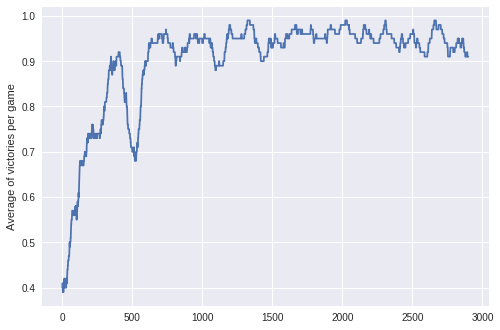

In [3]:

#matplotlib for rendering
import matplotlib.pyplot as plt
#Python image libarary for rendering
from PIL import Image
#iPython display for making sure we can render the frames
from IPython import display
from IPython.display import clear_output
#seaborn for rendering
import seaborn

#Setup matplotlib so that it runs nicely in iPython
%matplotlib inline
#setting up seaborn
seaborn.set()


def moving_average_diff(a, n=100):
    diff = np.diff(a)
    ret = np.cumsum(diff, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

plt.plot(moving_average_diff(win_hist))
plt.ylabel('Average of victories per game')
plt.show()
plt.savefig("test_3000epochs.png")

In [0]:
from google.colab import files
files.download('test_1000epochs.png')

In [14]:
!ls

datalab  model.h5  model.json  test_1000epochs.png  test_3000epochs.png


In [0]:
from google.colab import files
files.download('model.json') 
files.download('model.h5')